# Extend AI take-home project

## Part 2: loading and training YOLOv5

Download the YOLOv5 model 

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10148, done.
remote: Total 10148 (delta 0), reused 0 (delta 0), pack-reused 10148
Receiving objects: 100% (10148/10148), 10.44 MiB | 154.00 KiB/s, done.
Resolving deltas: 100% (7029/7029), done.


In [1]:
import torch
from IPython.display import Image  
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [83]:
cd ../labeled_images

/Users/programming/Desktop/extend_ai/extend-ai-ml-assessment/labeled_images


Convert PASCAL to YOLO, two steps: extract infos from xml and load info into txt in YOLO format

In [85]:
def info_from_xml(xml_file):
    
    root = ET.parse(xml_file).getroot()
    
    info_dict = {}
    info_dict['bboxes'] = []

    for elem in root:
        
        # File name 
        if elem.tag == 'filename':
            info_dict['filename'] = elem.text
            
        # Image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = float(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [87]:
# A check

test_path = 'Annotations/2021-04-07 21_36_40_exai_rpi_004_51_0.xml'

print(extract_from_xml(test_path))

{'bboxes': [{'class': 'knot', 'xmin': 175.25, 'ymin': 139.18, 'xmax': 188.83, 'ymax': 150.21}], 'filename': '2021-04-07 21_36_40_exai_rpi_004_51_0.jpg', 'image_size': (600, 600, 3)}


In [ ]:
CLASS_DICT = {"knot": 0, "crack": 1}

random.seed(0)
IMAGES_PATH = 'JPEGImages/'
LABELS_PATH = 'Annotations/'

In [90]:
annotations = [os.path.join(LABELS_PATH, x) for x in os.listdir(LABELS_PATH) if x[-3:] == "xml"].sort()

In [91]:
infos = []
for ann in tqdm(annotations):
    infos.append(info_from_xml(ann))

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 2099.82it/s]


In [92]:
def info_to_yolov5(info_dict):
    temp = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        class_id = CLASS_DICT[b["class"]]
        
        # get the YOLO v5 absolute format 
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # normalization
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width /= image_w 
        b_height /= image_h 
        
        # write the box
        temp.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    file_name = os.path.join(LABELS_PATH, info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(temp), file= open(file_name, "w"))

In [93]:
for info in tqdm(infos):
    into_to_yolov5(info)

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1874.75it/s]


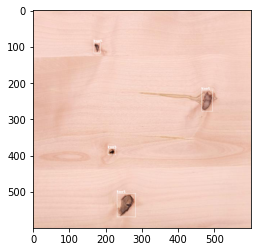

In [94]:
CLASS_DICT = dict(zip(CLASS_DICT.values(), CLASS_DICT.keys()))

# plotting function
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * image.size[0]
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * image.size[1]
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), CLASS_DICT[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

annotation_file = LABELS_PATH + '2021-04-07 21_39_06_exai_rpi_001_85_0.txt'
file = open(annotation_file, "r") 
annotation_list = file.read().split("\n")[:-1]
annotation_list = [x.split(" ") for x in annotation_list]
annotation_list = [[float(y) for y in x ] for x in annotation_list]



# load the image
image_file = annotation_file.replace(LABELS_PATH, IMAGES_PATH).replace("txt", "jpg")
image = Image.open(image_file)

# plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [95]:
# images and annotations
images = [os.path.join(IMAGES_PATH, x) for x in os.listdir(IMAGES_PATH)].sort()
annotations = [os.path.join(LABELS_PATH, x) for x in os.listdir(LABELS_PATH) if x[-3:] == "txt"].sort()

# train-valid-test split
train_images, val_images, train_annotations, val_annotations = \
        train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = \
        train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

Prepare the directories for the model

In [96]:
!mkdir JPEGImages/train JPEGImages/val \
        JPEGImages/test Annotations/train \
        Annotations/val Annotations/test

In [97]:
def move_files_to_folder(list_of_files, destination_folder):
    shutil.move(f, destination_folder)
        

# Move everything into its folders
move_files_to_folder(train_images, 'JPEGImages/train')
move_files_to_folder(val_images, 'JPEGImages/val/')
move_files_to_folder(test_images, 'JPEGImages/test/')
move_files_to_folder(train_annotations, 'Annotations/train/')
move_files_to_folder(val_annotations, 'Annotations/val/')
move_files_to_folder(test_annotations, 'Annotations/test/')

In [104]:
!mv Annotations labels
!mv JPEGImages images

In [105]:
cd ../yolov5

/Users/programming/Desktop/extend_ai/extend-ai-ml-assessment/yolov5


Train and test the model

In [108]:
!python train.py \
    --img 50 \
    --cfg yolov5s.yaml \
    --hyp hyp.scratch.yaml \
    --batch 2 \
    --epochs 100 \
    --data wood_analysis.yaml \
    --weights yolov5s.pt \
    --workers 24 \
    --name yolo_wood_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=wood_analysis.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=2, imgsz=50, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_wood_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-131-gc77a5a8 torch 1.10.0 CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v

      0/99        0G    0.1437 0.0004193   0.02106         1        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      0/99        0G    0.1503 0.0004435   0.02197         4        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      0/99        0G    0.1482 0.0004193   0.02156         1        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli


     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      2/99        0G         0 0.0002199         0         0        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      2/99        0G         0 0.0002223         0         0        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

      3/99        0G    0.2013  0.000526   0.02762         3        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      3/99        0G     0.179 0.0004933   0.02456         0        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      3/99        0G    0.1611 0.0004667    0.0221         0        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

      5/99        0G    0.1901   0.00131   0.02615         4        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      5/99        0G    0.1965 0.0008407   0.02713         3        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      5/99        0G    0.1983 0.0006748   0.02684         4        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

      6/99        0G    0.1964 0.0004482   0.02729         1        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      6/99        0G    0.1968  0.000462   0.02742         4        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      6/99        0G     0.196 0.0005181   0.02758         5        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

      8/99        0G    0.1883 0.0006318   0.02464         3        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      8/99        0G      0.19 0.0005528   0.02492         4        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      8/99        0G    0.1884 0.0005813   0.02575         1        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

      9/99        0G     0.136 0.0004617     0.019         0        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      9/99        0G    0.1415 0.0004586   0.01958         3        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
      9/99        0G    0.1458 0.0004461   0.01968         1        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     11/99        0G    0.1269 0.0005419   0.01634         2        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     11/99        0G    0.1435 0.0005025   0.01876         1        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     11/99        0G    0.1534 0.0004944   0.02027         3        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     12/99        0G    0.1931 0.0004019   0.02727         1        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     12/99        0G    0.1928 0.0004134   0.02743         4        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     12/99        0G    0.1925 0.0004325   0.02722         4        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     14/99        0G    0.1889 0.0005886    0.0272         2        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     14/99        0G    0.1862  0.000515   0.02795         1        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     14/99        0G    0.1878  0.000478   0.02724         1        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     15/99        0G    0.1426 0.0004345    0.0207         1        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     15/99        0G    0.1461  0.000465   0.02067         4        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     15/99        0G    0.1493 0.0004711   0.02134         2        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_m

     17/99        0G    0.1888 0.0006643   0.02516         4        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     17/99        0G    0.1889 0.0007029   0.02468         3        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     17/99        0G    0.1878 0.0007126   0.02473         3        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     18/99        0G    0.1855 0.0007317   0.02483         1        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     18/99        0G    0.1852 0.0007998   0.02481         5        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     20/99        0G    0.1804 0.0006797   0.02882         3        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     20/99        0G    0.1813 0.0006936    0.0281         3        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     20/99        0G    0.1586 0.0006352   0.02459         0        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     21/99        0G    0.1778 0.0009648   0.02533         5        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     22/99        0G    0.1826 0.0008513   0.02056         3        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     23/99        0G    0.1552 0.0006064   0.01979         2        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     23/99        0G    0.1569 0.0006423   0.01986         3        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     23/99        0G    0.1612 0.0005968   0.02007         1        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli


     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     25/99        0G    0.1957  0.000433   0.02261         1        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     25/99        0G    0.1822  0.001287   0.02385         3        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

     26/99        0G    0.1747  0.001141   0.02623         2        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     26/99        0G    0.1748   0.00112   0.02536         2        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     26/99        0G     0.173  0.001106   0.02487         1        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     28/99        0G         0 0.0002255         0         0        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     28/99        0G   0.08651  0.001223   0.01127         5        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     28/99        0G    0.1105  0.001165   0.01259         1        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     29/99        0G     0.176  0.001131   0.02295         2        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     29/99        0G    0.1748  0.001233   0.02292         4        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     29/99        0G    0.1748  0.001152   0.02333         2        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     31/99        0G     0.176  0.001156   0.02159         5        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     31/99        0G    0.1705  0.001119   0.02089         2        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     31/99        0G    0.1741  0.001073   0.02055         6        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     32/99        0G    0.1561  0.001293   0.01988         2        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     32/99        0G    0.1582  0.001258   0.02009         5        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     32/99        0G     0.145  0.001172   0.01841         0        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     34/99        0G    0.1705  0.001257    0.0214         2        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     34/99        0G    0.1659  0.001516   0.02239         2        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     34/99        0G    0.1666  0.001592   0.02144         4        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     35/99        0G    0.1706  0.001454   0.01894         5        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     35/99        0G    0.1711  0.001394   0.01889         2        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     35/99        0G    0.1711  0.001324   0.01867         1        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     37/99        0G    0.1507   0.00135   0.01912         1        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     37/99        0G    0.1539  0.001398   0.01951         4        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     37/99        0G    0.1282  0.001203   0.01626         0        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     38/99        0G    0.1356  0.001221   0.02243         0        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     38/99        0G    0.1388  0.001205   0.02264         5        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     38/99        0G    0.1412  0.001255    0.0225         6        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_m

     40/99        0G    0.1692  0.001431   0.02577         7        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     40/99        0G    0.1682  0.001287   0.02803         1        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     40/99        0G    0.1691  0.001267   0.02678         4        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     41/99        0G     0.131  0.001136   0.01582         0        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     41/99        0G    0.1336  0.001081   0.01542         1        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     43/99        0G    0.1672  0.001188   0.01965         6        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     43/99        0G    0.1655  0.001179   0.01873         1        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     43/99        0G    0.1639  0.001161   0.01795         1        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     44/99        0G    0.1392  0.001345   0.01654         1        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     45/99        0G    0.1616   0.00131   0.02465         2        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     46/99        0G    0.1149  0.001262    0.0142         2        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     46/99        0G    0.1215  0.001449   0.01504         6        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     46/99        0G    0.1265  0.001698   0.01515         6        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli


     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     48/99        0G    0.1692  0.002631   0.02144         7        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     48/99        0G    0.1666  0.002031   0.02561         4        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

     49/99        0G    0.1411  0.001769   0.01719         2        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     49/99        0G    0.1448  0.001619   0.01632         1        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     49/99        0G    0.1469  0.001531   0.01582         1        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     51/99        0G    0.1699 0.0007527   0.01093         2        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     51/99        0G    0.1674 0.0006345  0.009494         1        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     51/99        0G     0.166   0.00113   0.01115         4        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     52/99        0G    0.1266  0.001499   0.01537         0        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     52/99        0G     0.114  0.001371   0.01383         0        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     52/99        0G    0.1187  0.001499   0.01382         5        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     54/99        0G    0.1649  0.001219   0.03172         3        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     54/99        0G    0.1689  0.001032   0.03096         2        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     54/99        0G    0.1656  0.001835   0.02661         5        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     55/99        0G    0.1542  0.001993    0.0143         4        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     55/99        0G    0.1548  0.002051   0.01431         4        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     55/99        0G    0.1561  0.001961   0.01427         3        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     57/99        0G    0.1617  0.001246   0.02181         3        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     57/99        0G    0.1625   0.00147   0.01954         4        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     57/99        0G    0.1598  0.001522   0.01785         2        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     58/99        0G    0.1588  0.001592    0.0176         1        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     58/99        0G    0.1599  0.001522   0.01937         2        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     58/99        0G    0.1596  0.001513   0.01843         1        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     60/99        0G    0.1253  0.001037   0.01376         3        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     60/99        0G    0.1312  0.001044   0.01335         1        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     60/99        0G    0.1354  0.001166   0.01407         2        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     61/99        0G    0.1331  0.001379   0.01001         3        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     61/99        0G    0.1351  0.001399  0.009751         3        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     61/99        0G    0.1361  0.001555  0.009831         3        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_m

     63/99        0G    0.1581  0.001928   0.01234         7        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     63/99        0G    0.1569  0.001788   0.01086         1        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     63/99        0G    0.1592  0.001665     0.014         3        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     64/99        0G    0.1587  0.002513   0.01998         2        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     64/99        0G    0.1473  0.002349   0.01855         0        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     66/99        0G    0.1625  0.002608   0.01844         8        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     66/99        0G    0.1635  0.002535   0.01882         7        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     66/99        0G    0.1626  0.002699   0.01878         5        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     67/99        0G    0.1604  0.001953   0.01757         5        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     68/99        0G     0.163  0.001624    0.0102         3        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     69/99        0G    0.1281  0.001378   0.01129         1        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     69/99        0G    0.1299  0.001432   0.01152         2        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     69/99        0G    0.1317  0.001384   0.01097         1        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli


     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     71/99        0G     0.153  0.002587  0.008981         3        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     71/99        0G    0.1525  0.001775   0.02064         1        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

     72/99        0G    0.1522  0.001584   0.01456         1        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     72/99        0G    0.1538  0.001575   0.01423         4        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     72/99        0G    0.1543  0.001621   0.01465         4        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     74/99        0G     0.149  0.004442   0.01085         4        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     74/99        0G    0.1561  0.003631   0.01211         4        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     74/99        0G    0.1571  0.003289   0.01083         4        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     75/99        0G    0.1568   0.00193   0.02062         4        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     75/99        0G    0.1581  0.001828   0.01934         4        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     75/99        0G    0.1585  0.001708   0.01801         1        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     77/99        0G    0.1639 0.0008672   0.03048         2        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     77/99        0G    0.1654 0.0007434    0.0275         2        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     77/99        0G     0.165 0.0009065   0.02315         3        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     78/99        0G    0.1197  0.001284   0.01387         3        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     78/99        0G    0.1223  0.001465   0.01431         4        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     78/99        0G    0.1242  0.001555   0.01402         2        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     80/99        0G    0.1663  0.001054   0.03263         3        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     80/99        0G    0.1648    0.0016   0.02794         4        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     80/99        0G    0.1624  0.001749   0.02658         2        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     81/99        0G    0.1557  0.002286   0.01282         4        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     81/99        0G    0.1558  0.002359   0.01377         5        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     81/99        0G    0.1563   0.00226   0.01368         3        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     83/99        0G    0.1341  0.001623   0.03546         4        64:  29%|██▊/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     83/99        0G     0.135  0.001462   0.02886         1        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     83/99        0G    0.1376  0.001623   0.02899         4        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     84/99        0G    0.1389  0.003071   0.01175         3        64:  86%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     84/99        0G    0.1402   0.00296   0.01271         4        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     84/99        0G    0.1416  0.002963   0.01259         5        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_m

     86/99        0G    0.1266  0.001431  0.008557         0        64:  36%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     86/99        0G    0.1318  0.001299   0.01382         3        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     86/99        0G    0.1352  0.001379   0.01798         3        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     87/99        0G    0.1342  0.001502    0.0153         2        64:  93%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     87/99        0G    0.1353  0.001564   0.01478         2        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          8      0.002     0.0833    0.00115   0.000229

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     89/99        0G      0.14  0.001804   0.01025         4        64:  43%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     89/99        0G    0.1428  0.001648   0.01423         1        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     89/99        0G    0.1453  0.001521   0.01298         2        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     90/99        0G    0.1426  0.002393   0.01072         1        64: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          3          0          0          0          0          0

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     91/99        0G    0.1464   0.00192   0.01969         3        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type

     92/99        0G    0.1364  0.001545   0.02053         1        64:  50%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     92/99        0G    0.1393  0.001715   0.01939         5        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     92/99        0G    0.1408   0.00166    0.0177         2        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli


     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/14 [00:00<?, ?it/s]                                          /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     94/99        0G     0.166  0.002109   0.01095         5        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     94/99        0G    0.1601  0.002904   0.01016         4        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

     95/99        0G    0.1208  0.001403   0.02301         3        64:  57%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     95/99        0G    0.1264  0.001386    0.0216         4        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     95/99        0G    0.1137   0.00127   0.01944         0        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     97/99        0G    0.1627   0.00221   0.01744         4        64:   7%|▋  /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     97/99        0G    0.1624  0.001839   0.01879         2        64:  14%|█▍ /Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     97/99        0G    0.1619  0.001834   0.01874         5        64:  21%|██▏/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

     98/99        0G    0.1335  0.001767  0.009475         2        64:  64%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     98/99        0G    0.1351   0.00176  0.009166         2        64:  71%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
     98/99        0G    0.1367  0.001836  0.009917         3        64:  79%|███/Users/programming/opt/anaconda3/envs/extend_ai/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabli

Results saved to runs/train/yolo_wood_det6


In [115]:
!python detect.py --source ../labeled_images/images/test/ --weights runs/train/yolo_wood_det/weights/best.pt --conf 0.05 --name yolo_wood_det

detect: weights=['runs/train/yolo_wood_det/weights/best.pt'], source=../labeled_images/images/test/, imgsz=[640, 640], conf_thres=0.05, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_wood_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-131-gc77a5a8 torch 1.10.0 CPU

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /Users/programming/Desktop/extend_ai/extend-ai-ml-assessment/labeled_images/images/test/2021-04-07 21_36_40_exai_rpi_004_51_3.jpg: 640x640 2 knots, Done. (0.421s)
image 2/4 /Users/programming/Desktop/extend_ai/extend-ai-ml-assessment/labeled_images/images/test/2021-04-07 21_39_06_exai_rpi_001_85_4.jpg: 640x640 13 knots, Done. (0.408s)
image 3/4 /Users/programming/Desktop/extend_ai/ext